In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
df['Drug'].unique()

array(['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'], dtype=object)

In [5]:
df['Drug'].value_counts()

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

<Axes: xlabel='Drug'>

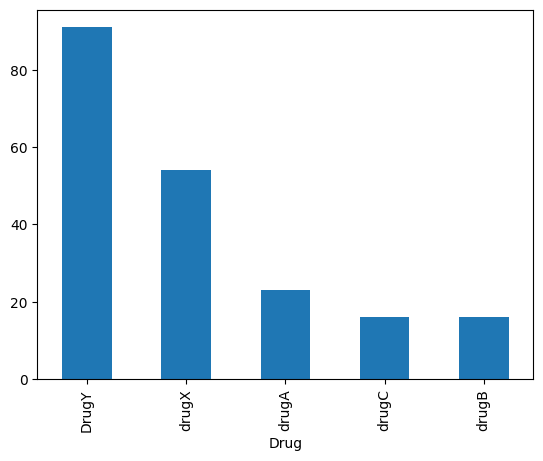

In [6]:
df['Drug'].value_counts().plot(kind='bar')

### Seperate X and Y

In [7]:
X = df.drop(labels=['Drug'],axis=1)
Y = df[['Drug']]

In [8]:
X.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [9]:
Y.head()

,Drug
0,DrugY
1,drugC
2,drugC
3,drugX
4,DrugY


## Label Encode Y values

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y['Drug']=le.fit_transform(Y['Drug'])

In [11]:
Y.value_counts()

Drug
0       91
4       54
1       23
2       16
3       16
Name: count, dtype: int64

In [12]:
df.isna().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

### Cat Con sep

In [13]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [14]:
cat

['Sex', 'BP', 'Cholesterol']

In [15]:
con

['Age', 'Na_to_K']

### Sklearn pipeline

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [17]:
num_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='mean')),
                           ('scaler',StandardScaler())])

cat_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore'))])

pre = ColumnTransformer([('num',num_pipe,con),
                         ('cat',cat_pipe,cat)])

In [18]:
X_pre =pre.fit_transform(X)
X_pre

array([[-1.29159102,  1.28652212,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.16269866, -0.4151454 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.16269866, -0.82855818,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.46567567, -0.85908883,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-1.29159102, -0.28650033,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.26146916, -0.6571702 ,  1.        , ...,  0.        ,
         0.        ,  1.        ]])

In [19]:
cols = pre.get_feature_names_out()
cols

array(['num__Age', 'num__Na_to_K', 'cat__Sex_F', 'cat__Sex_M',
       'cat__BP_HIGH', 'cat__BP_LOW', 'cat__BP_NORMAL',
       'cat__Cholesterol_HIGH', 'cat__Cholesterol_NORMAL'], dtype=object)

In [20]:
X_pre = pd.DataFrame(X_pre,columns=cols)
X_pre.head()

,num__Age,num__Na_to_K,cat__Sex_F,cat__Sex_M,cat__BP_HIGH,cat__BP_LOW,cat__BP_NORMAL,cat__Cholesterol_HIGH,cat__Cholesterol_NORMAL
0,-1.291591,1.286522,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.162699,-0.415145,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.162699,-0.828558,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.988614,-1.149963,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.011034,0.271794,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### Train test split

In [21]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre,Y,test_size=0.3,random_state=42,stratify=Y)

In [22]:
xtrain.shape

(140, 9)

In [23]:
xtest.shape

(60, 9)

### Gradient Boost Classifier

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.2,n_estimators=20,random_state=21)
gbc.fit(xtrain,ytrain)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=20, random_state=21)

In [25]:
gbc.score(xtrain,ytrain)

1.0

In [26]:
gbc.score(xtest,ytest)

0.95

### Predict

In [27]:
ypred_tr = gbc.predict(xtrain)
ypred_ts = gbc.predict(xtest)

## Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(ytest,ypred_ts)
cf

array([[27,  0,  0,  0,  0],
       [ 1,  6,  0,  0,  0],
       [ 0,  0,  5,  0,  0],
       [ 0,  0,  0,  4,  1],
       [ 1,  0,  0,  0, 15]], dtype=int64)

<Axes: >

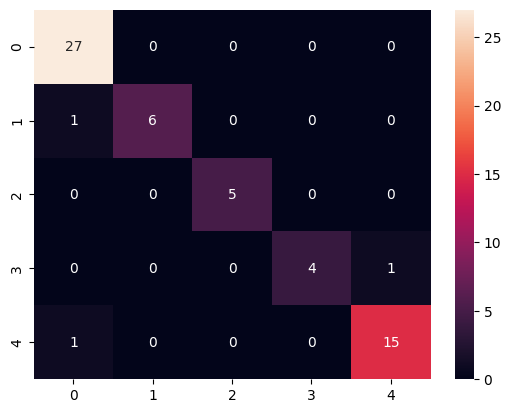

In [29]:
import seaborn as sns
sns.heatmap(cf,annot=True,fmt='d')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred_ts))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.86      0.92         7
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.94      0.94      0.94        16

    accuracy                           0.95        60
   macro avg       0.97      0.92      0.94        60
weighted avg       0.95      0.95      0.95        60



### Hyperparameter tuning

In [31]:
params = {'n_estimators':[5,10,15,20,25,50,100,150,200],
          'learning_rate':[0.01,0.1,0.2,0.3],
          'max_depth':[2,3,4,5,6,7,8]}

In [32]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
model = GradientBoostingClassifier(random_state=21)
skf = StratifiedKFold(n_splits=5)
rscv = RandomizedSearchCV(model,param_distributions=params,cv=skf,scoring='f1_macro')
rscv.fit(xtrain,ytrain)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(random_state=21),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'n_estimators': [5, 10, 15, 20, 25, 50,
                                                         100, 150, 200]},
                   scoring='f1_macro')

In [33]:
rscv.best_params_

{'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}

In [34]:
rscv.best_score_

0.9672380952380951

In [35]:
best_gbc = rscv.best_estimator_
best_gbc

GradientBoostingClassifier(n_estimators=150, random_state=21)

### Feature Importances

In [36]:
imp = pd.Series(best_gbc.feature_importances_)
imp.index = xtrain.columns
imp = imp.sort_values(ascending=False)
imp

num__Na_to_K               0.627923
cat__BP_HIGH               0.165427
num__Age                   0.079527
cat__Cholesterol_HIGH      0.040582
cat__BP_NORMAL             0.033489
cat__Cholesterol_NORMAL    0.026729
cat__BP_LOW                0.026321
cat__Sex_F                 0.000000
cat__Sex_M                 0.000000
dtype: float64

<Axes: title={'center': 'Feature Importances'}>

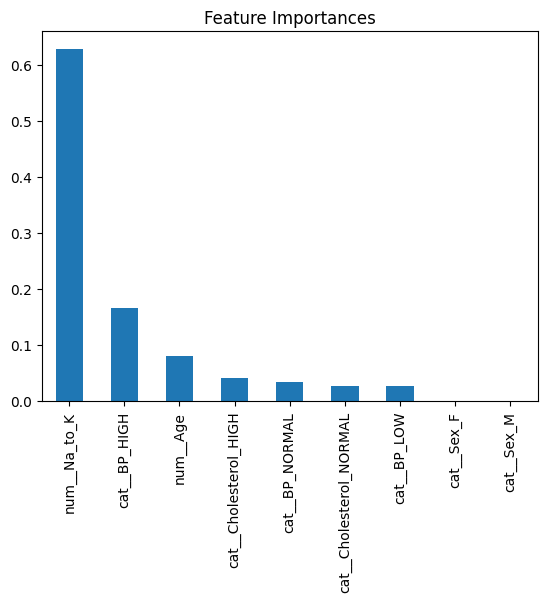

In [37]:
imp.plot(kind='bar',title='Feature Importances')

### Predicting with Best GBC

In [38]:
ypred_tr = best_gbc.predict(xtrain)
ypred_ts = best_gbc.predict(xtest)

In [39]:
ypred_tr

array([0, 0, 4, 0, 0, 0, 3, 0, 0, 1, 4, 0, 0, 0, 0, 4, 4, 0, 1, 0, 0, 1,
       3, 4, 4, 4, 0, 1, 4, 2, 4, 4, 0, 0, 3, 0, 0, 4, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 4, 4, 3, 0, 0, 2, 2, 0, 2, 4, 4, 4, 2, 3, 1, 1, 3,
       0, 4, 0, 4, 0, 0, 2, 4, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0,
       0, 1, 4, 3, 1, 4, 4, 0, 4, 0, 0, 3, 1, 4, 0, 1, 3, 0, 0, 2, 4, 3,
       1, 0, 0, 0, 0, 1, 0, 1, 4, 4, 1, 0, 2, 0, 0, 4, 4, 0, 4, 2, 0, 4,
       0, 4, 2, 4, 3, 4, 4, 4])

In [40]:
ytrain.head()

,Drug
143,0
92,0
117,4
21,0
141,0


In [41]:
ypred_ts

array([0, 0, 4, 0, 4, 4, 0, 4, 4, 0, 1, 3, 0, 0, 0, 1, 2, 0, 3, 2, 4, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 4, 4, 3, 4, 0, 0, 0, 4,
       0, 1, 0, 1, 4, 1, 4, 4, 1, 0, 2, 3, 2, 0, 4, 4])

In [42]:
ytest.head()

,Drug
97,0
175,0
30,4
153,4
160,4


### Confusion Matrix

In [43]:
cf2 = confusion_matrix(ytest,ypred_ts)
cf2

array([[27,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0],
       [ 0,  0,  5,  0,  0],
       [ 0,  0,  0,  4,  1],
       [ 1,  0,  0,  0, 15]], dtype=int64)

<Axes: >

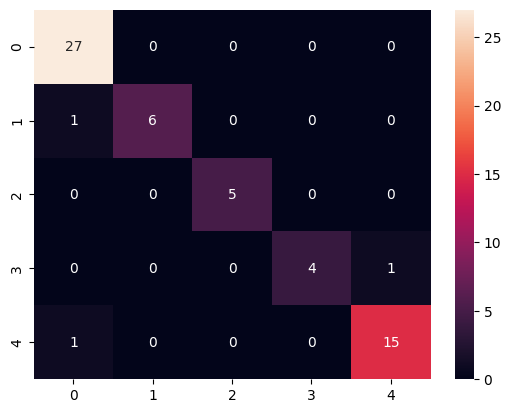

In [44]:
sns.heatmap(cf,annot=True,fmt='d')

### Classification Report

In [45]:
print(classification_report(ytest,ypred_ts))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.94      0.94      0.94        16

    accuracy                           0.97        60
   macro avg       0.98      0.95      0.96        60
weighted avg       0.97      0.97      0.97        60



### Getting actual labels back

In [46]:
tr_lb = le.inverse_transform(ypred_tr)
tr_lb

array(['DrugY', 'DrugY', 'drugX', 'DrugY', 'DrugY', 'DrugY', 'drugC',
       'DrugY', 'DrugY', 'drugA', 'drugX', 'DrugY', 'DrugY', 'DrugY',
       'DrugY', 'drugX', 'drugX', 'DrugY', 'drugA', 'DrugY', 'DrugY',
       'drugA', 'drugC', 'drugX', 'drugX', 'drugX', 'DrugY', 'drugA',
       'drugX', 'drugB', 'drugX', 'drugX', 'DrugY', 'DrugY', 'drugC',
       'DrugY', 'DrugY', 'drugX', 'DrugY', 'DrugY', 'drugA', 'DrugY',
       'DrugY', 'DrugY', 'DrugY', 'drugA', 'DrugY', 'DrugY', 'DrugY',
       'drugX', 'drugX', 'drugC', 'DrugY', 'DrugY', 'drugB', 'drugB',
       'DrugY', 'drugB', 'drugX', 'drugX', 'drugX', 'drugB', 'drugC',
       'drugA', 'drugA', 'drugC', 'DrugY', 'drugX', 'DrugY', 'drugX',
       'DrugY', 'DrugY', 'drugB', 'drugX', 'DrugY', 'drugX', 'DrugY',
       'DrugY', 'DrugY', 'DrugY', 'DrugY', 'DrugY', 'drugX', 'DrugY',
       'drugB', 'DrugY', 'DrugY', 'DrugY', 'DrugY', 'drugA', 'drugX',
       'drugC', 'drugA', 'drugX', 'drugX', 'DrugY', 'drugX', 'DrugY',
       'DrugY', 'dru

In [47]:
ts_lb = le.inverse_transform(ypred_ts)
ts_lb

array(['DrugY', 'DrugY', 'drugX', 'DrugY', 'drugX', 'drugX', 'DrugY',
       'drugX', 'drugX', 'DrugY', 'drugA', 'drugC', 'DrugY', 'DrugY',
       'DrugY', 'drugA', 'drugB', 'DrugY', 'drugC', 'drugB', 'drugX',
       'DrugY', 'DrugY', 'drugB', 'DrugY', 'DrugY', 'DrugY', 'DrugY',
       'DrugY', 'DrugY', 'drugA', 'DrugY', 'DrugY', 'DrugY', 'drugX',
       'DrugY', 'drugX', 'drugX', 'drugC', 'drugX', 'DrugY', 'DrugY',
       'DrugY', 'drugX', 'DrugY', 'drugA', 'DrugY', 'drugA', 'drugX',
       'drugA', 'drugX', 'drugX', 'drugA', 'DrugY', 'drugB', 'drugC',
       'drugB', 'DrugY', 'drugX', 'drugX'], dtype=object)